# Learning Objectives

- Understand how to define and expose Python functions as tools using the Model Context Protocol (MCP) server (`FastMCP`).
- Learn how to configure and launch an MCP server using the `stdio` transport mechanism.
- Grasp how to connect a LangChain/LangGraph agent to an MCP server, dynamically load the available tools, and utilize them within an agent workflow (`stdio_client`, `ClientSession`, `load_mcp_tools`).

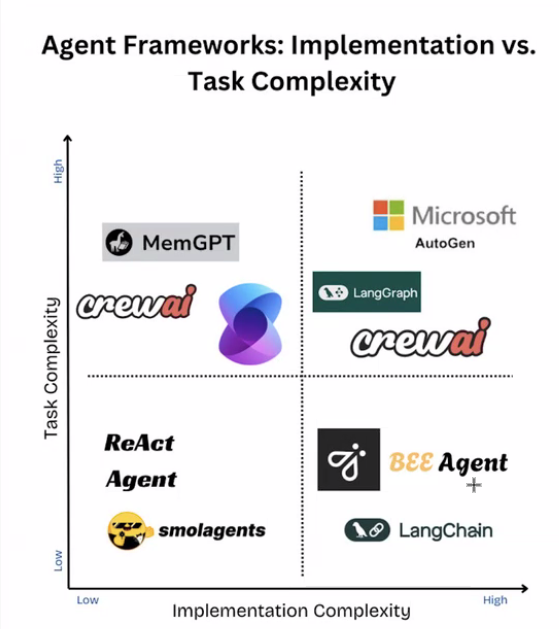

# Setup

## 📝 What’s happening?

- **`nest_asyncio`** → a Python library that allows you to **reuse or nest event loops**.  
- **`nest_asyncio.apply()`** → patches the current `asyncio` event loop so you can call `await` or run async code inside environments that already have a running loop (like **Jupyter Notebooks**, Google Colab, or IPython).  

---

## ⚡ Analogy  

Imagine you’re in a **classroom** where only **one person is allowed to talk at a time** (the event loop).  

- Normally, if someone is already talking (event loop is running), no one else can start.  
- But sometimes, you need someone inside the conversation to **ask a quick question and get an answer** without stopping the


In [1]:
import nest_asyncio
nest_asyncio.apply()

# Business Scenario

Imagine a financial services company wants to build an internal AI assistant for its analysts. This assistant needs to answer questions about stocks, requiring access to real-time pricing and company information. Instead of embedding API keys or complex data-fetching logic directly into the agent (which might be running in a less secure environment or be harder to update), the company creates a dedicated MCP server.

This server securely wraps the necessary functions (like querying Yahoo Finance). The analyst interacts with the AI assistant (the client-side code), which securely communicates with the MCP tool server via stdio to fetch the required data, enabling the assistant to provide informed answers without directly handling the data source interaction itself. This pattern allows for easy updates to the tools (just update the server) and better separation of concerns.

# Implementation Roadmap

1. Goal: Create an LLM-based agent that can answer financial questions using real-time data from Yahoo Finance.
2. Challenge: LLMs lack direct, real-time access to external APIs like Yahoo Finance. We need a way to provide this capability.
3. Solution Approach: Use the Model Context Protocol (MCP) to bridge the gap.
    - Server (`yfserver.py`):
        - Define Tools: Create Python functions (`get_current_price`, `get_company_info`, `list_popular_tickers`) that use the yfinance library to fetch the required data.
        - Expose Tools via MCP: Use the `FastMCP` library and the `@mcp.tool()` decorator to expose these Python functions as callable tools over the MCP protocol. The decorator helps automatically define the tool's schema (inputs, outputs, description) based on type hints and docstrings.
        - Run the Server: Configure the MCP server to run and communicate using `stdio` (standard input/standard output). This is a simple transport mechanism suitable for local process communication.
    - Client (Main Notebook/Script):
        - Configure LLM: Set up the connection to the desired Large Language Model (e.g., ChatOpenAI).
        - Launch Server Process: Define how to start the `yfserver.py` script as a separate process (`StdioServerParameters`).
        - Establish MCP Connection: Use the `stdio_client` context manager to start the server process and get access to its stdin and stdout streams. Inside this, use the `ClientSession` context manager to establish an MCP session over these streams and perform the initial handshake (`session.initialize()`).
        - Discover Tools: Utilize the `langchain-mcp-adapters` library (`load_mcp_tools`) to automatically query the connected MCP server, discover the available tools, and convert them into LangChain-compatible Tool objects.
        - Create Agent: Instantiate a LangChain/LangGraph agent (like `create_react_agent`), providing it with the LLM and the dynamically loaded tools.
        - Execute Query: Pass the user's natural language query to the agent. The agent will use the LLM to plan steps, decide when to use a tool, invoke the tool (which triggers communication over MCP to the server process), receive the results, and generate a final response.

4. Rationale: This architecture decouples the agent's core reasoning logic (LLM) from the specific implementation of the tools. The MCP server acts as a secure and maintainable gateway to the external Yahoo Finance functionality. `stdio` is chosen for simplicity in this example, allowing the client script to directly manage the server process lifecycle. The `langchain-mcp-adapters` library simplifies the integration by handling the MCP communication details and tool conversion automatically.

### 📝 Building a Yahoo Finance LLM Agent

#### 1. Goal
Create an AI agent that can **answer financial questions using real-time data from Yahoo Finance**.

#### 2. Challenge
LLMs **cannot access external APIs** (like Yahoo Finance) directly. We need a way to **connect the AI to live data**.

#### 3. Solution: Use MCP (Model Context Protocol)

Think of MCP as a **translator/bridge** between the AI and real-world tools.

##### a. Server (`yfserver.py`) – “The Data Chef”
- **Define Tools:** Python functions like `get_current_price`, `get_company_info`, `list_popular_tickers` fetch live data using the `yfinance` library.  
- **Expose Tools via MCP:** Use `@mcp.tool()` decorator → automatically describes what each tool does and its inputs/outputs.  
- **Run Server:** Communicate via `stdio` (like sending messages through a pipe) — simple, no complex networking needed.  

##### b. Client (Notebook/Script) – “The AI Assistant”
- **Configure LLM:** Connect to a Large Language Model (e.g., ChatOpenAI).  
- **Launch Server:** Start `yfserver.py` as a separate process using `StdioServerParameters`.  
- **Establish MCP Connection:** Use `stdio_client` + `ClientSession` → handshake with server and get access to its tools.  
- **Discover Tools:** `load_mcp_tools` queries the server and converts its tools into **AI-friendly objects**.  
- **Create Agent:** Set up a LangChain/LangGraph agent with the LLM + available tools.  
- **Execute Query:**  
  1. User asks a question.  
  2. Agent decides **which tool to use**.  
  3. Tool fetches real-time data from the server.  
  4. Agent combines results and generates a final answer.  

#### 4. Analogy Summary
- **Server (`yfserver.py`)** = The chef cooking fresh data.  
- **LLM/Agent** = The assistant asking the chef for ingredients (data) and making a meal (answer).  
- **MCP + stdio** = The kitchen counter where they pass ingredients back and forth efficiently.  

#### 5. Why This Architecture?
- Keeps the **LLM separate from real-world data tools** → easier to maintain.  
- MCP + `langchain-mcp-adapters` handle the **messy plumbing** automatically.  
- Using `stdio` makes it **simple to run locally** without networking headaches.


# Server-side Implementation

In [4]:
%%writefile yfserver.py
# -- SERVER SIDE (Yahoo Finance MCP Server) --

# ---------------- Imports ---------------- #
import yfinance as yf  # For stock market data
from typing import Dict, Any, Optional  # Type hints
from pydantic import BaseModel  # Data validation with Pydantic
from datetime import datetime  # For timestamps

from mcp.server.fastmcp import FastMCP, Context  # MCP server utilities

# ---------------- Initialize MCP Server ---------------- #
# Create an MCP server instance with a descriptive name
mcp = FastMCP("Yahoo Finance API")

# ---------------- Data Model ---------------- #
# Pydantic model to validate and structure filter inputs
class SectorFilter(BaseModel):
    sector: Optional[str] = None  # Optional argument, e.g., "Technology"

# ---------------- Tool 1: Get Current Price ---------------- #
@mcp.tool()
def get_current_price(ticker: str, ctx: Context = None) -> Dict[str, Any]:
    """
    Fetch the current (latest closing) price of a stock.

    Args:
        ticker: Stock symbol (e.g., AAPL, MSFT)
    """
    # Log request to server console (if context is provided)
    if ctx:
        ctx.info(f"Fetching current price for {ticker}")

    try:
        ticker_obj = yf.Ticker(ticker)
        hist = ticker_obj.history(period="1d")  # Get 1-day history

        if hist.empty:
            return {"error": "No data available"}

        # Last closing price = "current" price
        price = hist['Close'].iloc[-1]
        return {
            "symbol": ticker,
            "price": round(price, 2),
            "currency": "USD",
            "timestamp": datetime.now().isoformat()
        }
    except Exception as e:
        # Handle errors gracefully
        return {"error": str(e)}

# ---------------- Tool 2: Get Company Info ---------------- #
@mcp.tool()
def get_company_info(ticker: str, ctx: Context = None) -> Dict[str, Any]:
    """
    Get detailed company information.

    Args:
        ticker: Stock symbol (e.g., AAPL, MSFT)
    """
    if ctx:
        ctx.info(f"Fetching company information for {ticker}")

    try:
        ticker_obj = yf.Ticker(ticker)
        info = ticker_obj.info  # Dictionary of metadata about the company

        # Extract key fields
        relevant_info = {
            "symbol": ticker,
            "name": info.get("shortName", "Unknown"),
            "longName": info.get("longName", "Unknown"),
            "sector": info.get("sector", "Unknown"),
            "industry": info.get("industry", "Unknown"),
            "website": info.get("website", "Unknown"),
            "marketCap": info.get("marketCap"),
            "forwardPE": info.get("forwardPE"),
            "dividendYield": info.get("dividendYield"),
            "trailingEps": info.get("trailingEps"),
            "description": info.get("longBusinessSummary", "No description available"),
        }
        return relevant_info
    except Exception as e:
        return {"error": str(e)}

# ---------------- Tool 3: List Popular Tickers ---------------- #
@mcp.tool()
def list_popular_tickers(filter: SectorFilter = SectorFilter()) -> Dict[str, Any]:
    """
    List popular stock tickers, optionally filtered by sector.

    Args:
        filter: SectorFilter with optional sector name
                (Technology, Consumer, Financial, Healthcare, Energy)
    """
    # Hardcoded popular tickers (for demo purposes)
    popular_tickers = {
        "Technology": ["AAPL", "MSFT", "GOOGL", "META", "NVDA"],
        "Consumer": ["AMZN", "WMT", "COST", "MCD", "NKE"],
        "Financial": ["JPM", "BAC", "V", "MA", "BRK-B"],
        "Healthcare": ["JNJ", "PFE", "UNH", "ABBV", "MRK"],
        "Energy": ["XOM", "CVX", "COP", "SLB", "EOG"],
    }

    sector = filter.sector  # Optional input

    if sector and sector in popular_tickers:
        # Return tickers for a specific sector
        return {
            "sector": sector,
            "tickers": [{"symbol": s, "uri": f"/tickers/{s}"} for s in popular_tickers[sector]]
        }
    elif sector:
        # Invalid sector input
        return {"error": f"Sector '{sector}' not found", "available_sectors": list(popular_tickers.keys())}
    else:
        # Return all tickers if no sector is specified
        return {
            sec: [{"symbol": s, "uri": f"/tickers/{s}"} for s in tks]
            for sec, tks in popular_tickers.items()
        }

# ---------------- Run MCP Server ---------------- #
# Standard Python pattern: run server only if script is executed directly
if __name__ == "__main__":
    # Transport = "stdio" → MCP communicates via standard input/output
    mcp.run(transport="stdio")


Overwriting yfserver.py


In the above code block:
- `%%writefile yfserver.py`: This Jupyter/Colab magic command saves the content of this cell into a file named `yfserver.py`. This file contains the server-side logic.
- `mcp = FastMCP("Yahoo Finance API")`: Initializes an MCP server instance, giving it a descriptive name.
- `class SectorFilter(BaseModel)`: Defines a Pydantic model to represent the expected structure for the filter argument in `list_popular_tickers`. It allows an optional sector string. Pydantic handles validation.
- `@mcp.tool()`: This decorator registers the decorated Python function (get_current_price, get_company_info, list_popular_tickers) as a tool accessible via the MCP protocol. MCP automatically uses the function's signature (name, arguments, type hints) and docstring to create a schema/description for the tool, which the client can discover.
- Tool Functions (`get_current_price`, etc.):
    - These functions implement the actual logic using the yfinance library.
    - They accept arguments as defined in their signature (e.g., `ticker: str`). `list_popular_tickers` uses the `SectorFilter` Pydantic model for its filter argument.
    - They include basic try...except blocks to handle potential errors during API calls and return an error dictionary if something goes wrong.
    - They return data structured as Python dictionaries, which MCP will serialize (likely to JSON) for transport.
    - The optional `ctx: Context` argument allows access to MCP server context, used here for logging (ctx.info).
- `if __name__ == "__main__": mcp.run(transport='stdio')`: This standard Python construct ensures that `mcp.run()` is called only when the script `yfserver.py` is executed directly. `mcp.run(transport='stdio')` starts the MCP server, making it listen for requests and send responses via the process's standard input and standard output streams.

# Client-side Implementation

## Setting up server access

In [5]:
# -- Client Side --
import os
import asyncio
import subprocess

from mcp import ClientSession, StdioServerParameters
from mcp.client.stdio import stdio_client

from langchain_mcp_adapters.tools import load_mcp_tools
from langgraph.prebuilt import create_react_agent

from langchain_openai import AzureChatOpenAI

In [6]:
import nest_asyncio
nest_asyncio.apply()

In [7]:
azure_api_key = os.getenv('azure_api_key')
# Modify the Azure Endpoint and the API Versions as needed
azure_base_url = os.getenv('azure_base_url')
azure_api_version = os.getenv('azure_api_version')

In [8]:
llm = AzureChatOpenAI(
    azure_endpoint=azure_base_url,
    api_key=azure_api_key,
    api_version=azure_api_version,
    model='gpt-4o-mini',
    temperature=0
)

### 📝 Explanation of `StdioServerParameters`

- **StdioServerParameters** → A LangChain/LangGraph helper class that tells the client how to start and talk to the server.  
- **Stdio** = Standard Input/Output (like a terminal).  
- The server (`yfserver.py`) communicates using **stdin/stdout**, not HTTP or sockets.  

**Parameters:**
- `command="python"` → The shell command to run. Here, it means: **Run Python**.  
- `args=['yfserver.py']` → Arguments passed to the command. So the full command becomes:  

```bash
python yfserver.py


In [17]:
server_params = StdioServerParameters(
    command="python",
    args=['yfserver.py']
)

In the above code block:
- `StdioServerParameters:` Configures how the client should launch the server process. It specifies the command (python) and the arguments (`yfserver.py`). This tells `stdio_client` how to start the server when needed.

## Main asynchronous function

### 📝 Async Functions in Python

#### 1. What is an async function?
In Python, an **async function** is a special type of function that can run **asynchronously** — meaning it can pause its execution to wait for something (like data from the internet, a file, or another process) **without blocking the rest of the program**.  

#### 2. How it works
- Normally, Python functions run line by line, **blocking** the program until each step is finished.  
- **Async functions** can use `await` to pause their execution at certain points, letting **other tasks run in the meantime**.  

#### 3. Key points
- `async def` → Defines an asynchronous function.  
- `await` → Tells Python: “Pause here, let other async tasks run, and resume when ready.”  
- **Non-blocking** → Other code can run while waiting for I/O (like web requests or reading files).  
- **Requires an event loop** → Async functions run inside an `asyncio` event loop (Python’s scheduler for async tasks).  

#### 4. Analogy
Think of async like **cooking while waiting for water to boil**:  
- Normal function = Stand there watching the water boil → do nothing else.  
- Async function = Put the water on the stove, then chop veggies while waiting → more efficient!


### 📝 Explanation of `async with stdio_client(...) as (read, write)`

#### 1. Context
- `stdio_client` is a helper that **connects your Python code (client) to the MCP server** using **standard input/output (stdin/stdout)**.  
- `server_params` tells it **how to start the server** (`yfserver.py`) as a separate process.  
- `errlog=subprocess.PIPE` captures **any error messages** from the server so you can see them in Python.

#### 2. How it works
- `async with` → This is **asynchronous context management**, meaning Python will **wait for the server to start** without blocking other async tasks.  
- `(read, write)` → These are **streams to communicate with the server**:
  - `read` → Read data coming **from the server**.  
  - `write` → Send data **to the server**.  

#### 3. What happens
1. Python starts `yfserver.py` using the `server_params`.  
2. It **opens two communication channels**: one for reading, one for writing.  
3. Once connected, you can **send commands or requests** to the server and **receive responses**.  
4. After the block ends, the connection **automatically closes** safely.

#### 4. Analogy
Think of it like **chatting with a chef in the kitchen**:
- `write` = You hand the chef a note with instructions (like “get me Apple stock price”).  
- `read` = Chef writes back the result on a note.  
- `async with` = Ensures the conversation happens smoothly **without stopping other tasks in the house**.


In [18]:
# import subprocess
# import traceback
# from langchain.agents import create_react_agent
# from mcp.client.stdio import stdio_client
# from mcp.client.session import ClientSession

# Async function to handle a user query with MCP client
import traceback
async def main(user_query: str):
    """
    Runs the MCP client to send a user query to the MCP server (yfserver.py).
    It discovers tools, builds an agent, and invokes it with the query.
    """

    print(f"\n🚀 Starting MCP client for query: '{user_query}'")
    agent_response = None  # Placeholder for final response

    try:
        # 1. Start MCP server process (python yfserver.py)
        #    and connect via stdio (stdin/stdout).
        async with stdio_client(server_params, errlog=subprocess.PIPE) as (read, write):
            print("✅ Connected to MCP server (stdio_client).")

            try:
                # 2. Open a session (MCP handshake happens here).
                async with ClientSession(read, write) as session:
                    await session.initialize()
                    print("✅ ClientSession initialized (handshake complete).")

                    # 3. Discover available tools from the server.
                    tools = await load_mcp_tools(session)
                    print(f"🛠️ Tools discovered: {[tool.name for tool in tools]}")

                    # 4. Create a ReAct agent using the LLM and discovered tools.
                    agent = create_react_agent(llm, tools)
                    print("🤖 Agent created. Ready to handle the query.")

                    # 5. Prepare the input (conversation style).
                    agent_input = {"messages": [("user", user_query)]}

                    # 6. Send query to the agent (async call) using ainvoke.
                    print("📩 Sending query to agent...")
                    agent_response = await agent.ainvoke(agent_input)
                    print("✅ Agent finished processing.")

            except Exception as session_err:
                # Errors inside the ClientSession (handshake, tools, agent).
                print("\n❌ ERROR inside ClientSession context:")
                traceback.print_exc()
                agent_response = {
                    "error": "ClientSession failed",
                    "details": str(session_err),
                }

        # Returning result (could be agent output or error dict)
        return agent_response

    except Exception as e:
        # Errors during server startup/teardown (outside ClientSession).
        print("\n❌ ERROR outside ClientSession (server setup/teardown):")
        traceback.print_exc()
        print("----------------------------------------------------")
        return {
            "error": "Agent execution failed unexpectedly",
            "details": str(e),
        }


In the above code block:
- `async def main(user_query)`: Defines an asynchronous function that encapsulates the client logic for processing a single user query.
- `async with stdio_client(...)`: This asynchronous context manager:
    - Starts the server process using the `server_params` defined earlier (`python yfserver.py`).
    - Establishes communication by connecting to the server process's standard input and output.
    - Provides read and write asynchronous stream objects for communication.
    - `errlog=subprocess.PIPE` captures the server's standard error stream, useful for debugging server-side issues.
    - Ensures the server process is properly terminated when the context is exited.
- `async with ClientSession(read, write)`: Inside the `stdio_client` context, this creates an MCP `ClientSession` using the provided read and write streams. This session manages the MCP protocol communication.
- `await session.initialize()`: Performs the essential MCP handshake between the client and the server. During this phase, the client typically learns about the server's capabilities, including the available tools.
- `tools = await load_mcp_tools(session)`: This is the key integration point provided by langchain-mcp-adapters. It communicates with the initialized MCP session, discovers the tools defined on the server (like `get_current_price`), and automatically wraps them into LangChain-compatible Tool objects.
- `agent = create_react_agent(llm, tools)`: Creates a LangGraph agent using the create_react_agent prebuilt graph. It's configured with the llm and the list of tools obtained from the MCP server. The ReAct (Reasoning and Acting) agent framework allows the LLM to reason about which tool to use, invoke it, observe the result, and continue until it can answer the query.
- `agent_input = ...`: Formats the user query into the expected input structure for the LangGraph agent (a list of messages).
- `agent_response = await agent.ainvoke(agent_input)`: Executes the agent asynchronously with the user query. The agent will now potentially call the MCP tools (triggering communication through the ClientSession -> stdio_client -> server process) as part of its reasoning process.
- Error Handling: Includes `try...except` blocks to catch and report errors that might occur during the connection, session initialization, tool loading, or agent execution phases.

### Example 1

In [28]:
user_query = "Tesla company information?"

In [29]:
response = asyncio.run(main(user_query))


🚀 Starting MCP client for query: 'Tesla company information?'
✅ Connected to MCP server (stdio_client).
✅ ClientSession initialized (handshake complete).
🛠️ Tools discovered: ['get_current_price', 'get_company_info', 'list_popular_tickers']
🤖 Agent created. Ready to handle the query.
📩 Sending query to agent...
✅ Agent finished processing.


In [30]:
print(response['messages'][-1].content)

Here is the company information for Tesla, Inc. (TSLA):

- **Name**: Tesla, Inc.
- **Sector**: Consumer Cyclical
- **Industry**: Auto Manufacturers
- **Website**: [tesla.com](https://www.tesla.com)
- **Market Capitalization**: $1,117,295,869,952
- **Forward P/E Ratio**: 106.91
- **Trailing EPS**: 1.66
- **Dividend Yield**: Not applicable

**Description**: 
Tesla, Inc. designs, develops, manufactures, leases, and sells electric vehicles, as well as energy generation and storage systems in the United States, China, and internationally. The company operates in two segments: Automotive and Energy Generation and Storage. 

- The **Automotive segment** offers electric vehicles, automotive regulatory credits, non-warranty after-sales vehicle services, used vehicles, body shop and parts, supercharging, retail merchandise, and vehicle insurance services. It also provides sedans and sport utility vehicles through direct and used vehicle sales, a network of Tesla Superchargers, in-app upgrades, p

### Example 2

In [22]:
user_query = "Give me detailed company information about some popular stocks in the Technology sector"

In [23]:
response = asyncio.run(main(user_query))


🚀 Starting MCP client for query: 'Give me detailed company information about some popular stocks in the Technology sector'
✅ Connected to MCP server (stdio_client).
✅ ClientSession initialized (handshake complete).
🛠️ Tools discovered: ['get_current_price', 'get_company_info', 'list_popular_tickers']
🤖 Agent created. Ready to handle the query.
📩 Sending query to agent...
✅ Agent finished processing.


In [24]:
print(response['messages'][-1].content)

Here is the detailed company information for some popular stocks in the Technology sector:

### 1. Apple Inc. (AAPL)
- **Website:** [apple.com](https://www.apple.com)
- **Market Cap:** $3.53 trillion
- **Forward P/E:** 28.63
- **Dividend Yield:** 0.44%
- **Trailing EPS:** 6.59
- **Description:** Apple Inc. designs, manufactures, and markets smartphones, personal computers, tablets, wearables, and accessories worldwide. The company offers products like the iPhone, Mac, iPad, and various services including AppleCare, cloud services, and subscription-based services like Apple Music and Apple TV+. Founded in 1976, it is headquartered in Cupertino, California.

### 2. Microsoft Corporation (MSFT)
- **Website:** [microsoft.com](https://www.microsoft.com)
- **Market Cap:** $3.70 trillion
- **Forward P/E:** 33.32
- **Dividend Yield:** 0.67%
- **Trailing EPS:** 13.65
- **Description:** Microsoft Corporation develops and supports software, services, devices, and solutions worldwide. Its segments

<font size=6; color='blue'> **Happy Learning!** </font>
___